**Before starting ...**

Checking we are using frugal-notebooks-env conda environment

In [1]:
!which python

/Users/a.villa.massone/miniconda3/envs/frugal-notebooks-env/bin/python


Checking the python version is 3.9 (compatibility with frugal AI codebase)

In [2]:
!python --version

Python 3.9.21


Checking the pytorch version is > 1.12+ (compatibility with MPS)

In [3]:
import torch
print(torch.__version__)

2.5.1.post201


# Text classification exploration

## Let's explore the dataset

**Loading the dataset**

In [4]:
import pandas as pd

df = pd.read_parquet("hf://datasets/QuotaClimat/frugalaichallenge-text-train/train.parquet")

In [5]:
df.head(3)

,quote,label,source,url,language,subsource,id
0,"There is clear, compelling evidence that many ...",5_science_unreliable,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None
1,"For most of the Holocene (last 10k years), sea...",1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test1,None
2,"China, which hosts U.N. climate talks next wee...",4_solutions_harmful_unnecessary,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None


**We will only use the quote and label columns**

In [6]:
df.columns

Index(['quote', 'label', 'source', 'url', 'language', 'subsource', 'id'], dtype='object')

In [7]:
df = df[['quote', 'label']]
df.head()

,quote,label
0,"There is clear, compelling evidence that many ...",5_science_unreliable
1,"For most of the Holocene (last 10k years), sea...",1_not_happening
2,"China, which hosts U.N. climate talks next wee...",4_solutions_harmful_unnecessary
3,And the fabricated documents (which Dr. Mann a...,0_not_relevant
4,It's going to be 42 here today and the hottest...,1_not_happening


**The label have 8 classes**

In [8]:
print('unique values:')
print('label\n', df['label'].unique())

unique values:
label
 ['5_science_unreliable' '1_not_happening'
 '4_solutions_harmful_unnecessary' '0_not_relevant' '6_proponents_biased'
 '7_fossil_fuels_needed' '2_not_human' '3_not_bad']


**No duplicate quotes**

In [9]:
df['quote'].duplicated().sum()

0

**But we have a bit of unbalanced classes (that we will have to take care of for models that need training)**

In [10]:
class_distribution = df['label'].value_counts().sort_index()
df['label'].value_counts(normalize=True).sort_index()

label
0_not_relevant                     0.265638
1_not_happening                    0.121655
2_not_human                        0.115252
3_not_bad                          0.063372
4_solutions_harmful_unnecessary    0.127073
5_science_unreliable               0.131505
6_proponents_biased                0.128386
7_fossil_fuels_needed              0.047119
Name: proportion, dtype: float64

In [11]:
import plotly.express as px

fig = px.bar(x=class_distribution.index, y=class_distribution.values, 
             labels={'x': 'Label', 'y': 'Count'})
fig.update_layout(width=900, height=400, title="Class Distribution")
fig.show(renderer='iframe')

**No missing values**

In [12]:
missing_values = df.isnull().sum()
print(missing_values)

quote    0
label    0
dtype: int64


**We might need to crop some quotes**

In [13]:
df['text_length'] = df['quote'].str.len()
print(df['text_length'].describe())

count    6091.000000
mean      293.528485
std       258.330755
min        19.000000
25%       139.000000
50%       228.000000
75%       365.000000
max      4703.000000
Name: text_length, dtype: float64


In [14]:
fig = px.histogram(df, x='text_length', nbins=50)
fig.update_layout(width=800, height=400, title="Sentence Length Distribution")
fig.show(renderer='iframe')

In [15]:
import numpy as np
threshold = np.percentile(df['text_length'], 90)
threshold

544.0

In [16]:
long_quotes = df[df['text_length'] > threshold]
print('Number of quotes above threshold: ', long_quotes.shape[0])

Number of quotes above threshold:  608


In [17]:
df['truncated_quote'] = df['quote'].str.slice(0, int(threshold))
df.head()

,quote,label,text_length,truncated_quote
0,"There is clear, compelling evidence that many ...",5_science_unreliable,277,"There is clear, compelling evidence that many ..."
1,"For most of the Holocene (last 10k years), sea...",1_not_happening,279,"For most of the Holocene (last 10k years), sea..."
2,"China, which hosts U.N. climate talks next wee...",4_solutions_harmful_unnecessary,286,"China, which hosts U.N. climate talks next wee..."
3,And the fabricated documents (which Dr. Mann a...,0_not_relevant,146,And the fabricated documents (which Dr. Mann a...
4,It's going to be 42 here today and the hottest...,1_not_happening,123,It's going to be 42 here today and the hottest...


## LLM Baseline

In [18]:
# mistral, phi2, qwen

selected_model = "mistral"

**Model set-up**

In [19]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [20]:
MODEL_NAMES = {
    "mistral": "mistralai/Mistral-7B-Instruct-v0.1",
    "phi2": "microsoft/phi-2",
    "qwen": "Qwen/Qwen2.5-0.5B"
}
# "Qwen/Qwen2.5-7B"
# "Qwen/Qwen2.5-0.5B"
# "Qwen/Qwen2.5-1.5B"

#if torch.cuda.is_available():            # Nvidia GPU (T4)
#    DEVICE = "cuda"
#elif torch.backends.mps.is_available():  # Apple Silicon (M3)
#    DEVICE = "mps"
#else:
#    DEVICE = "cpu"

CLASS_LABELS = [
    "0_not_relevant",
    "1_not_happening",
    "2_not_human",
    "3_not_bad",
    "4_solutions_harmful_unnecessary",
    "5_science_unreliable",
    "6_proponents_biased",
    "7_fossil_fuels_needed"
]

In [21]:
def load_model(model_name):

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
#        torch_dtype=(torch.float32 if DEVICE == "mps" else torch.float16),
        torch_dtype=torch.float16,
        device_map="auto"           # Auto-detects MPS (Apple Silicon)
    ).eval()                        # Disables dropout for consistent results

    return tokenizer, model

**Loading the model**

In [22]:
%%time
model_name = MODEL_NAMES[selected_model]
tokenizer, model = load_model(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the disk.


CPU times: user 9.86 s, sys: 7.41 s, total: 17.3 s
Wall time: 29 s


In [23]:
!ls ~/.cache/huggingface/hub/

models--Qwen--Qwen2.5-0.5B
models--Qwen--Qwen2.5-7B
models--mistralai--Mistral-7B-Instruct-v0.1
version.txt


In [24]:
!du -sh ~/.cache/huggingface/hub/models--mistralai--Mistral-7B-Instruct-v0.1

 13G	/Users/a.villa.massone/.cache/huggingface/hub/models--mistralai--Mistral-7B-Instruct-v0.1


In [25]:
# to clear the cache
# from huggingface_hub.utils import hf_hub_download
# hf_hub_download.clear_cache()

**Prompt**

In [26]:
def create_prompt(text):
    pass
    return f"""Classify this climate statement into ONE category. Respond ONLY with the corresponding number (0-7).

Statement: {text}

Categories:
0 - Not relevant to climate change : 
No relevant claim detected or claims that don't fit other categories

1 - Climate change is not happening : 
Claims denying the occurrence of global warming and its effects - Global warming is not happening. 
Climate change is NOT leading to melting ice (such as glaciers, sea ice, and permafrost), increased extreme weather, or rising sea levels. Cold weather also shows that climate change is not happening

2 - Climate change is not caused by humans.
Claims denying human responsibility in climate change.
Greenhouse gases from humans are not the causing climate change.

3 - Climate change is not bad.
Claims minimizing or denying negative impacts of climate change.
The impacts of climate change will not be bad and might even be beneficial.

4 - Solutions to climate change are bad.
Claims against climate solutions.
Climate solutions are harmful or unnecessary

5 - Science is unreliable.
Claims questioning climate science validity
Climate science is uncertain, unsound, unreliable, or biased.

6 - Climate activists are bad.
Claims attacking climate scientists and activists
Climate scientists and proponents of climate action are alarmist, biased, wrong, hypocritical, corrupt, and/or politically motivated.

7 - Fossil fuels are a necessity.
Claims promoting fossil fuel necessity
We need fossil fuels for economic growth, prosperity, and to maintain our standard of living.

Category number:"""

In [ ]:
def create_prompt(text):
    return f"""Classify this statement into ONE climate change category (0-7). Respond STRICTLY with only the corresponding number.

Statement: {text}

Categories:
0 - Not relevant to climate change:
No climate-related claims detected, or content unrelated to other categories.
"New sports stadium approved" | "Latest smartphone features"

1 - Climate change is not happening:
Explicitly denies global warming occurrence or its measurable impacts (e.g., rejects links to melting ice, extreme weather, sea level rise, or uses cold weather as counter-evidence).
"Global warming stopped in 2016" | "Record cold proves no climate change"

2 - Climate change is not caused by humans:
Attributes climate change primarily to natural causes, denying anthropogenic greenhouse gas influence.
"CO2 doesn't affect climate" | "Climate changes are natural cycles"

3 - Climate change is not bad:
Minimizes negative consequences or claims net benefits from climate change.
"Warmer winters will be better" | "CO2 helps plant growth"

4 - Climate solutions are harmful:
Opposes mitigation strategies as unnecessary, harmful, or counterproductive.
"Solar power ruins economies" | "EVs cause more pollution"

5 - Climate science is unreliable:
Challenges scientific consensus, methods, or motives in climate research.
"Climate models are guesses" | "Temperature data is fake"

6 - Climate actors are untrustworthy:
Attacks credibility/motives of scientists, activists, or institutions promoting climate action.
"Scientists are lying for grants" | "Activists want to control us"

7 - Fossil fuels are essential:
Asserts fossil fuels are critical for economic stability and quality of life.
"Oil is essential for progress" | "Coal keeps lights on"

Category number:"""

In [37]:
def create_prompt(text):
    pass
    return f"""Classify this climate statement into ONE category. Respond ONLY with the corresponding number (0-7).

Think step-by-step.

Categories:
0 - Not relevant to climate change : 
No relevant claim detected or claims that don't fit other categories

1 - Climate change is not happening : 
Claims denying the occurrence of global warming and its effects - Global warming is not happening. 
Climate change is NOT leading to melting ice (such as glaciers, sea ice, and permafrost), increased extreme weather, or rising sea levels. Cold weather also shows that climate change is not happening

2 - Climate change is not caused by humans.
Claims denying human responsibility in climate change.
Greenhouse gases from humans are not the causing climate change.

3 - Climate change is not bad.
Claims minimizing or denying negative impacts of climate change.
The impacts of climate change will not be bad and might even be beneficial.

4 - Solutions to climate change are bad.
Claims against climate solutions.
Climate solutions are harmful or unnecessary

5 - Science is unreliable.
Claims questioning climate science validity
Climate science is uncertain, unsound, unreliable, or biased.

6 - Climate activists are bad.
Claims attacking climate scientists and activists
Climate scientists and proponents of climate action are alarmist, biased, wrong, hypocritical, corrupt, and/or politically motivated.

7 - Fossil fuels are a necessity.
Claims promoting fossil fuel necessity
We need fossil fuels for economic growth, prosperity, and to maintain our standard of living.

Statement: {text}

Category number:"""

**Prediction function**

In [38]:
import time
from codecarbon import EmissionsTracker

def classify_text(text, tokenizer, model):
    prompt = create_prompt(text)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    tracker = EmissionsTracker(log_level="warning")
    tracker.start()
    
    start_time = time.time()

    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids,
            max_new_tokens=2,
            temperature=0,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    end_time = time.time()
    emissions = tracker.stop()

    inference_time = end_time - start_time

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return response, inference_time, emissions

    
def parse_output(response):
    prediction = response.split("Category number:")[-1].strip()
    prediction = ''.join(filter(str.isdigit, prediction))
    
    if prediction.isdigit() and int(prediction) in range(8):
        return CLASS_LABELS[int(prediction)]
    return "error"

**Testing on a single sample**

In [39]:
df['truncated_quote'][0]

'There is clear, compelling evidence that many of the major conclusions of the IPCC, your new religions constantly-changing Holy Book, are based on evidence that has been fabricated. The hockey stick graph that purported to abolish the mediaeval warm period is just one example.'

In [40]:
%%time
sample_text = df['truncated_quote'][0]

prediction, latency, energy_conso = classify_text(sample_text, tokenizer, model)

print(f"Model device: {model.device}")
print(f"next(model.parameters()).device: {next(model.parameters()).device}")
print(f"Inputs device: {inputs['input_ids'].device}")

print(prediction)
print(f"inference latency :{latency:.2f} seconds")
print(f"energy_conso :{energy_conso:.4f}")
prediction = parse_output(prediction)
print(f"\nText: {sample_text}\nPrediction: {prediction}\nTrue label: {df['label'][0]}")

[codecarbon WARNING @ 11:49:52] No CPU tracking mode found. Falling back on CPU constant mode.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[codecarbon WARNING @ 11:49:52] We saw that you have a Apple M3 but we don't know it. Please contact us.
/Users/a.villa.massone/miniconda3/envs/frugal-notebooks-env/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:567: UserWarning:

`do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.



Model device: mps:0
next(model.parameters()).device: mps:0


NameError: name 'inputs' is not defined

**Evaluation on larger sample**

In [41]:
N_SAMPLES = 50

In [42]:
import random
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [43]:
random.seed(42)
torch.manual_seed(42)

test_samples = df.sample(N_SAMPLES, random_state=42)
texts = test_samples['truncated_quote'].tolist()
true_labels = test_samples['label'].tolist()

In [44]:
%%time

predictions = []
latencies = []
energy_conso = []
errors = 0

for text, true_label in zip(texts, true_labels):
    try:
        pred, lat, ems = classify_text(text, tokenizer, model)

        pred = parse_output(pred)
        predictions.append(pred)
        latencies.append(lat)
        energy_conso.append(ems)

        if pred == "error":
            errors += 1
    except Exception as e:
        predictions.append("error")
        errors += 1
        print(f"Error processing: {text[:50]}... -> {str(e)}")

[codecarbon WARNING @ 11:50:05] No CPU tracking mode found. Falling back on CPU constant mode.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[codecarbon WARNING @ 11:50:06] We saw that you have a Apple M3 but we don't know it. Please contact us.
/Users/a.villa.massone/miniconda3/envs/frugal-notebooks-env/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:567: UserWarning:

`do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.

[codecarbon WARNING @ 11:50:16] No CPU tracking mode found. Falling back on CPU constant mode.
huggingface/tokenizers: The current proces

CPU times: user 23.4 s, sys: 5min 22s, total: 5min 46s
Wall time: 11min 15s


In [45]:
results = pd.DataFrame({
    'text': [t[:100]+'...' for t in texts],
    'true': true_labels,
    'pred': predictions
})
results["correct"] = results["true"] == results["pred"]

total_latency = np.sum(latencies)
average_latency = np.mean(latencies)
total_energy_conso = np.sum(energy_conso)
average_energy_conso = np.mean(energy_conso)
average_power_W = total_energy_conso * 1000 / total_latency

print(f"total_latency for {N_SAMPLES} samples: {total_latency:.2f} seconds")
print(f"average_latency: {average_latency:.2f} seconds per sample")
print(f"total_energy_conso: {total_energy_conso:.6f} kWh")
print(f"average_energy_conso: {average_energy_conso:.6f} kWh per sample")
print(f"Average Power Consumption: {average_power_W:.6f} W")

total_latency for 50 samples: 586.67 seconds
average_latency: 11.73 seconds per sample
total_energy_conso: 0.000487 kWh
average_energy_conso: 0.000010 kWh per sample
Average Power Consumption: 0.000830 W


In [46]:
results.head()

,text,true,pred,correct
0,Mann could be said to be the Jerry Sandusky of...,6_proponents_biased,6_proponents_biased,True
1,The reality is that the infra-red active gases...,2_not_human,0_not_relevant,False
2,“Late 20th century and early 21st century glob...,3_not_bad,1_not_happening,False
3,Our research has shown that the concentration ...,2_not_human,1_not_happening,False
4,I am speaking only as a layman who observes th...,1_not_happening,1_not_happening,True


**Metrics**

/Users/a.villa.massone/miniconda3/envs/frugal-notebooks-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Evaluation for 50 samples
Average latency per sample: 11.73 seconds
Average energy consumption : 0.000010 kgCO₂eq
Accuracy (excluding errors): 36.00%
Error rate: 0.00%


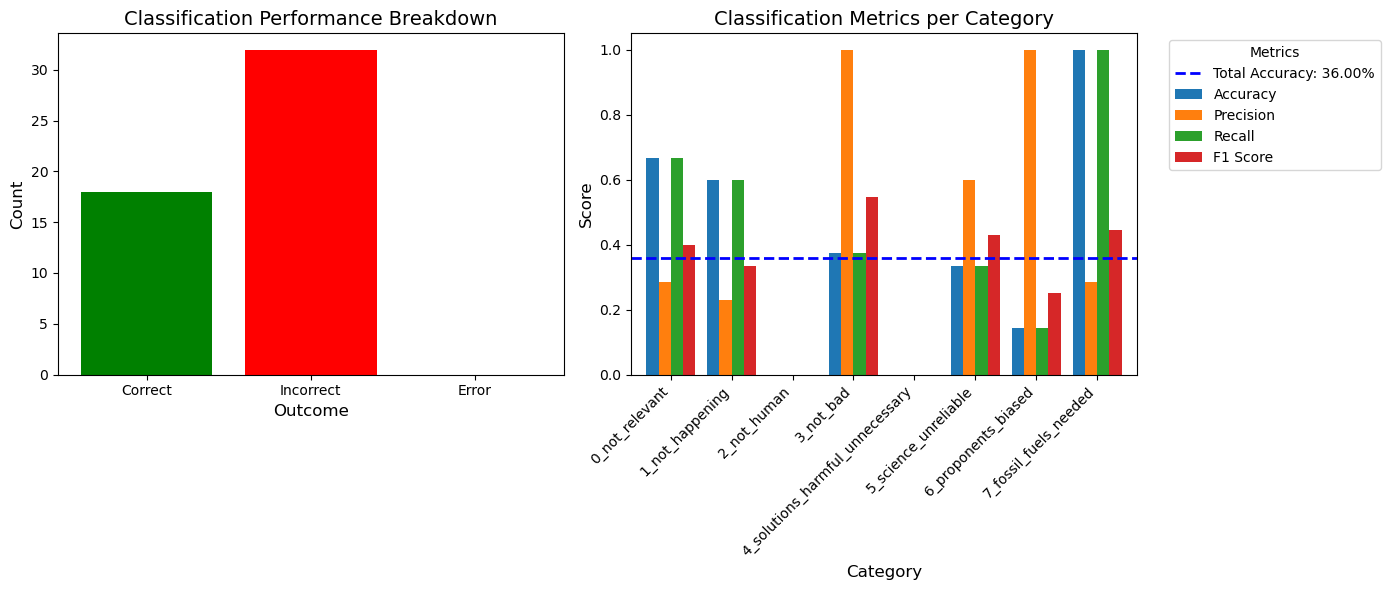

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute basic metrics
correct = np.sum(results["correct"])
accuracy = accuracy_score(results["true"], results["pred"])
category_names = sorted(results["true"].unique())

precision = precision_score(results["true"], results["pred"], average=None, labels=category_names)
recall = recall_score(results["true"], results["pred"], average=None, labels=category_names)
f1 = f1_score(results["true"], results["pred"], average=None, labels=category_names)
class_accuracy = pd.DataFrame(results).groupby("true")["correct"].mean().values

# Create a DataFrame with the metrics per category
metrics_df = pd.DataFrame({
    "Category": category_names,
    "Accuracy": class_accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

print(f"Evaluation for {N_SAMPLES} samples")
print(f"Average latency per sample: {average_latency:.2f} seconds")
print(f"Average energy consumption : {average_energy_conso:.6f} kgCO₂eq")
print(f"Accuracy (excluding errors): {accuracy:.2%}")
print(f"Error rate: {errors/N_SAMPLES:.2%}")

# Compute performance breakdown
performance = pd.DataFrame({
    'Outcome': ['Correct', 'Incorrect', 'Error'],
    'Count': [
        correct,
        len(results) - correct - errors,
        errors
    ]
})

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot: Classification performance breakdown
axes[0].bar(performance['Outcome'], performance['Count'], color=['green', 'red', 'gray'])
axes[0].set_title("Classification Performance Breakdown", fontsize=14)
axes[0].set_ylabel("Count", fontsize=12)
axes[0].set_xlabel("Outcome", fontsize=12)

# Second plot: Classification metrics per category
metrics_df.set_index("Category").plot(kind="bar", width=0.8, ax=axes[1])
axes[1].axhline(y=accuracy, color='blue', linestyle='dashed', linewidth=2, label=f'Total Accuracy: {accuracy:.2%}')
axes[1].set_title("Classification Metrics per Category", fontsize=14)
axes[1].set_ylabel("Score", fontsize=12)
axes[1].set_xlabel("Category", fontsize=12)
axes[1].set_xticklabels(metrics_df["Category"], rotation=45, ha="right")
axes[1].legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Let's save the results**

In [48]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
timestamp

'2025-01-28_12:01:23'

In [49]:
filename = (
    "metrics/"
    f"{'_'.join(model_name.split('/'))}"
    f"_accuracy_{int(accuracy * 100)}"
    f"_dt_{timestamp.replace(':', '').replace('-', '')}"
    ".json"
)
filename

'metrics/mistralai_Mistral-7B-Instruct-v0.1_accuracy_36_dt_20250128_120123.json'

In [50]:
note = "Baseline SLM, prompt engineering - quote cropping, no fine-tune"

In [51]:
# ajouter category metrics

import json
import os

os.makedirs("metrics", exist_ok=True)

data = {
    "model_name": model_name,
    "timestamp": timestamp,
    "accuracy": accuracy,
    "average_latency_sec": average_latency,
    "average_energy_consumption_kWh": total_energy_conso,
    "average_power_W": average_power_W,
    "sample_base" : N_SAMPLES,
    "note": note,
    "class_metrics": metrics_df.to_dict(orient="records")
}

with open(filename, "w") as f:
    json.dump(data, f, indent=4)

print(f"Metrics saved to {filename}")

Metrics saved to metrics/mistralai_Mistral-7B-Instruct-v0.1_accuracy_36_dt_20250128_120123.json
